In [ ]:
import copy
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    get_logging_dir,
    plot_data_split,
    plot_predictions,
)
from utils.federated_learning import average_models
from utils.self_learning_network import SelfLearningNet, combine

torch.manual_seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [12, 12, 12, 12]

LOSS_FN = torch.nn.MSELoss()

NUM_CLIENTS = 2
CLIENT_IDs = range(NUM_CLIENTS)

COMMUNICATION_ROUNDS = 100
CLIENT_EPOCHS = 100

SPLIT_TYPE = "random"

Communication Round 9\100
 global model:  ModuleList(
  (0): Linear(in_features=2, out_features=15, bias=False)
  (1): Linear(in_features=16, out_features=24, bias=False)
  (2-3): 2 x Linear(in_features=25, out_features=24, bias=False)
  (4): Linear(in_features=25, out_features=2, bias=False)
  (5): Linear(in_features=3, out_features=1, bias=False)
  (6-14): 9 x Linear(in_features=2, out_features=1, bias=False)
)

KeyboardInterrupt: 

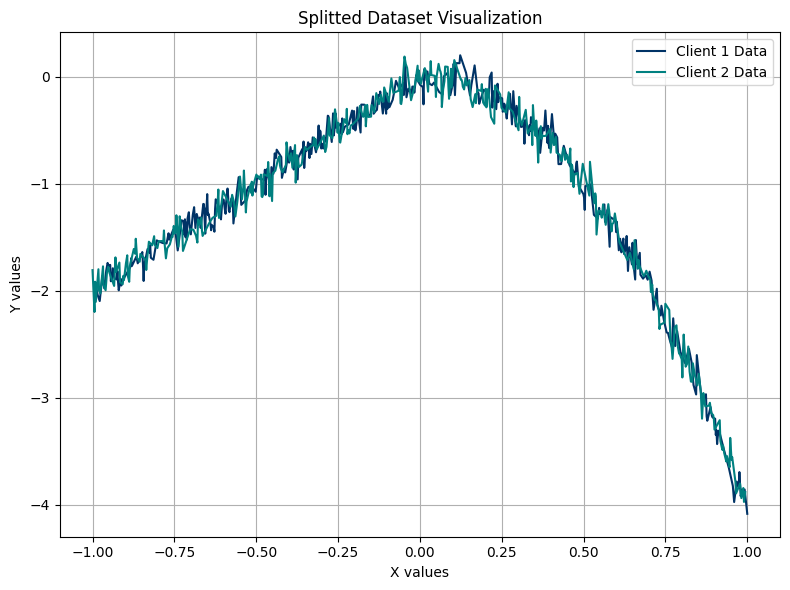

In [ ]:
model_name = f"MyFed_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name))

clients = [
    SelfLearningNet(ARCHITECTURE, INPUT_FEATURES, OUTPUT_FEATURES) for _ in CLIENT_IDs
]

client_train_dataloaders = data.get_client_test_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)
plot_data_split(client_train_dataloaders, writer)

client_optimizers: list[None | torch.optim.Optimizer] = [None for _ in CLIENT_IDs]


for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        client.train()

        client_optimizers[client_no] = torch.optim.Adam(
            clients[client_no].parameters(), lr=0.001
        )

        # train each client for certain epochs
        for ce in range(CLIENT_EPOCHS):
            losses = []
            for x, y in client_train_dataloaders[client_no]:
                client_optimizers[client_no].zero_grad()
                y_hat = client(x)
                loss = LOSS_FN(y_hat, y)
                loss.backward()
                client_optimizers[client_no].step()

                losses.append(loss.item())

            writer.add_scalar(
                f"loss/client{client_no}",
                sum(losses) / len(losses),
                cr * CLIENT_EPOCHS + ce,
            )

    for client, client_no in zip(clients, CLIENT_IDs):
        writer.add_scalar(f"test_loss/client{client_no}", evaluate(client), cr)

    if cr == COMMUNICATION_ROUNDS - 1:
        global_model = average_models(clients)
    else:
        global_model = combine(
            clients[0],
            clients[1],
            similarity_threshold_in_degree=10,
            new_weight_initialization="noise",
        )

    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    #### ----- Unimportant ----- TODO: remove
    from IPython.display import clear_output
    clear_output(wait=True)
    print(f"Communication Round {cr}\{  COMMUNICATION_ROUNDS }")
    print("\r global model: ", global_model.layers, end="")
    #### //// ----- Unimportant -----


    clients = [copy.deepcopy(global_model) for _ in CLIENT_IDs]

    if cr == COMMUNICATION_ROUNDS - 2:
        for client in clients:
            client.freeze_all()
            client.unfreeze_layer(-1)
            client.unfreeze_output_scaling()

plot_predictions(global_model, model_name, writer)
writer.add_hparams(
    {
        "client_epochs": CLIENT_EPOCHS,
        "num_clients": NUM_CLIENTS,
        "communication_rounds": COMMUNICATION_ROUNDS,
        "split_type": SPLIT_TYPE,
        "architecture": str(ARCHITECTURE)
    },
    {
        "MSE Test": evaluate(global_model),
    },
    run_name=".",
)
writer.close()